In [4]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
%matplotlib inline


def preprocess_damage_data(damage_data):
    damage_data['DmgCls'] = damage_data['DmgCls'].replace({None: 'No damage'})
    damage_data['geometry_tuple'] = damage_data['geometry'].apply(lambda point: (point.x, point.y))
    damage_data['latitude'] = damage_data['geometry'].apply(lambda point: point.y)
    damage_data['longitude'] = damage_data['geometry'].apply(lambda point: point.x)
    return damage_data

def get_image_index_from_annotation(annotation_data, city_data):
    return annotation_data.apply(lambda x: pd.Series({key: i for key, i in zip(['row', 'col'], city_data.index(x['longitude'], x['latitude']))}), axis=1)
    
def crop_annotation_to_image_dimensions(annotation_data, dimensions):
    mask = (annotation_data['row'] < dimensions['height'])\
        & (annotation_data['row'] >= 0)\
        & (annotation_data['col'] < dimensions['width'])\
        & (annotation_data['col'] >= 0)
    return annotation_data.loc[mask]

def raster_to_array(raster_data):
    raster_array = raster_data.read(indexes=[1,2,3])
    raster_array = np.swapaxes(np.swapaxes(raster_array, 1, 2), 0, 2)
    return raster_array

def plot_raster(raster_data):
    raster_array = raster_to_array(raster_data)
    plot_image(raster_array)
    
def plot_image(image):
    fix, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(image)
    

In [5]:
file_name_annotation = '../data/Damage_Sites_Damascus_2017_Ex_Update.shp'
file_name_city = '../data/damascus_2017_01_22_zoom_19.tif'
annotation_data = gpd.read_file(file_name_annotation)
annotation_data = preprocess_damage_data(annotation_data)
damascus_raster = rasterio.open(file_name_city)
damascus_array = raster_to_array(damascus_raster)
image_index = get_image_index_from_annotation(annotation_data, damascus_raster)
annotation_data = pd.merge(annotation_data, image_index, left_index=True, right_index=True)
annotation_data = crop_annotation_to_image_dimensions(annotation_data, {'height': damascus_raster.height, 'width': damascus_raster.width})
print(annotation_data.shape)
annotation_data.head()

(12601, 22)


,SiteID,SensDate,SensorID,ConfID,DmgCls,SensDate_2,SensorID_2,ConfID_2,DmgCls_2,DmgSts_2,...,Notes,Settl_Name,Neigh,EventCode,geometry,geometry_tuple,latitude,longitude,row,col
0,Building (General / Default),2016-04-02,Worldview-2,Very High,Destroyed,2017-12-03,WorldView-3,Very High,Destroyed,No change,...,None,Damascus,Unknown,CE20130604SYR,POINT (36.33532038400006 33.53922281800004),"(36.335320384000056, 33.53922281800004)",33.539223,36.335320,1659,658
1,Building (General / Default),2016-04-02,Worldview-2,Very High,Severe Damage,2017-12-03,WorldView-3,Very High,Destroyed,Increase - damage,...,None,Damascus,Unknown,CE20130604SYR,POINT (36.33341618400004 33.53820987600005),"(36.33341618400004, 33.53820987600005)",33.538210,36.333416,1848,303
2,Building (General / Default),2016-04-02,Worldview-2,Medium,Moderate Damage,2017-12-03,WorldView-3,Medium,Destroyed,Increase - damage,...,None,Damascus,Unknown,CE20130604SYR,POINT (36.33395225400005 33.53850257700003),"(36.33395225400005, 33.53850257700003)",33.538503,36.333952,1793,403
3,Building (General / Default),2016-04-02,Worldview-2,Medium,Moderate Damage,2017-12-03,WorldView-3,Medium,Destroyed,Increase - damage,...,None,Damascus,Unknown,CE20130604SYR,POINT (36.33391607800007 33.53840391300002),"(36.33391607800007, 33.538403913000025)",33.538404,36.333916,1812,396
4,Building (General / Default),2016-04-02,Worldview-2,Medium,Moderate Damage,2017-12-03,WorldView-3,Medium,Destroyed,Increase - damage,...,None,Damascus,Unknown,CE20130604SYR,POINT (36.33349182600006 33.53833484900008),"(36.333491826000056, 33.53833484900008)",33.538335,36.333492,1825,317


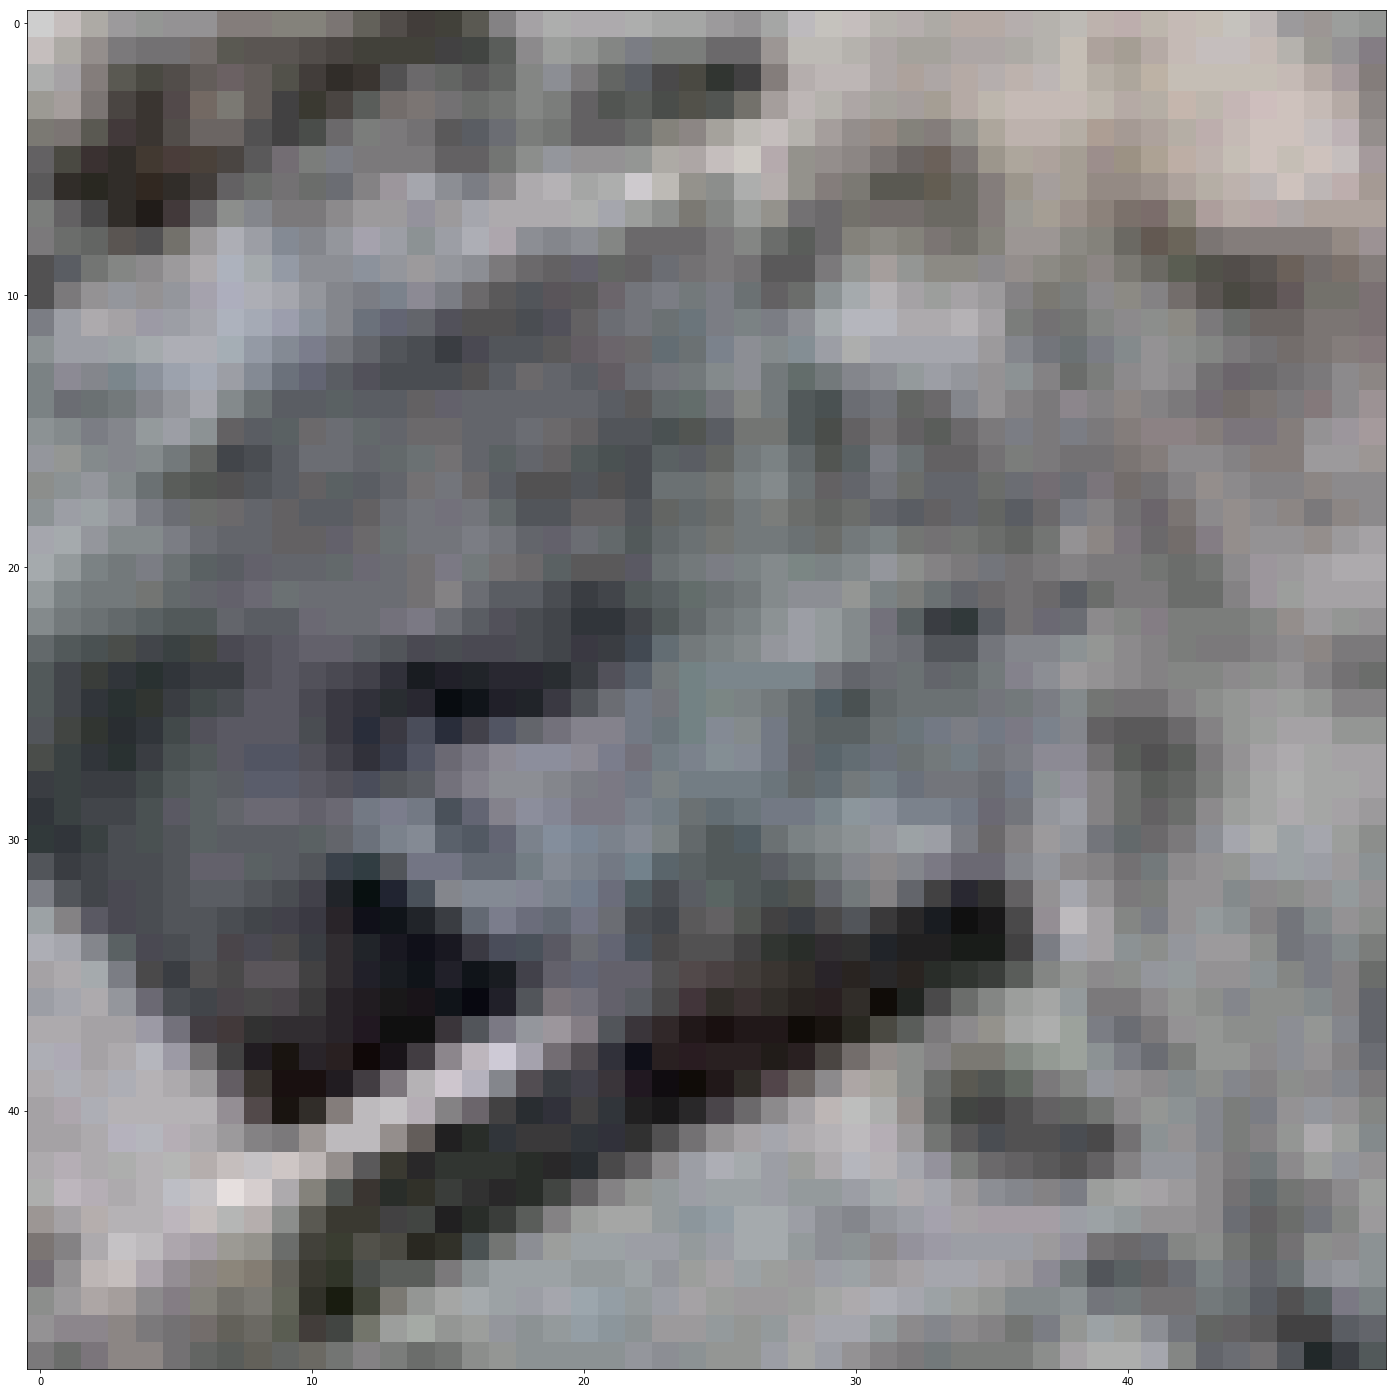

In [6]:
window = 50
assert (window) % 2 == 0
extra_pixels = int((window)/2)
row, col = annotation_data.iloc[0]['row'], annotation_data.iloc[0]['col']
building = damascus_array[(row-extra_pixels):(row+extra_pixels), (col-extra_pixels):(col+extra_pixels), :].reshape(window, window, 3)
plot_image(building)

# Modelling

In [50]:
### Modelling
import tensorflow as tf
from tensorflow.contrib.slim.python.slim.nets import resnet_v2
from tensorflow.layers import conv2d, max_pooling2d, dense, Flatten


def create_feature_matrix(city_array, annotation_data, window=50):
    assert (window) % 2 == 0
    extra_pixels = int((window)/2)
    feature_data = []
    for ix, row in annotation_data.iterrows():
        pixel_row, pixel_col = row['row'], row['col']
        building = get_building_frame(city_array, pixel_row, pixel_col, extra_pixels)
        feature_data.append({'image': building, 'target': (row['DmgCls_2'] == 'Destroyed') * 1})
        
    return pd.DataFrame(feature_data)
    
    
def get_building_frame(city_array, row, col, extra_pixels):
    return city_array[(row-extra_pixels):(row+extra_pixels), (col-extra_pixels):(col+extra_pixels), :]
    

class DataStream:
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.images_per_batch = batch_size
        self.current_batch_num = 0
        
    def get_batch(self):
        x_batch = self.x[(self.current_batch_num*self.images_per_batch):((self.current_batch_num+1)*self.images_per_batch)]
        y_batch = self.y[(self.current_batch_num*self.images_per_batch):((self.current_batch_num+1)*self.images_per_batch)]
        return x_batch, y_batch
        
    def update(self):
        self.current_batch_num += 1
        
    def restart(self):
        self.current_batch_num = 0
        

class NetworkFactory: 
    def create_network(self, network, **kwargs):
        network = self.get_network(network, **kwargs)
        return network
    
    def get_network(self, network, **kwargs):
        if network == 'resnet':
            return ResNetNetwork(**kwargs)
        elif network == 'cnn':
            return CNN(**kwargs)
        else:
            raise ValueError(network)
    

class ResNetNetwork:
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def get_output(self, x):
        out, end_points = resnet_v2.resnet_v2_101(x, num_classes=self.num_classes)
        out_squeezed = tf.squeeze(out, axis=[1,2])
        return out_squeezed, end_points
        
        
class CNN:
    def __init__(self, num_classes, convolutional_layers):
        self.num_classes = num_classes
        self.convolutional_layers = convolutional_layers
    
    def get_output(self, x):
        layers = []
        for config in self.convolutional_layers:
            if not layers:
                layers.append(self.create_convolutional_and_pooling_layer(inputs=x, **config))
            else:
                layers.append(self.create_convolutional_and_pooling_layer(inputs=layers[-1], **config))
        
        layer_flat = self.flatten_layer(layers[-1])
        logits = tf.layers.dense(inputs=layer_flat, units=self.num_classes, activation=tf.nn.relu)
        return logits, None
        
    def create_convolutional_and_pooling_layer(self, inputs, filters, 
                                               kernel_size, pool_size):
        conv = conv2d(inputs=inputs, filters=filters, kernel_size=kernel_size,
                      padding="same", activation=tf.nn.relu)
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=pool_size, strides=pool_size[0])
        return pool
    
    def flatten_layer(self, layer):
        return Flatten()(layer)

        
class ClassificationNetwork:
    def __init__(self, image_shape, weight_positives, network):
        self.image_shape = image_shape
        self.weight_positives = weight_positives
        self.network = network
        self._create_network()
    
    def _create_placeholders(self):
        shape_x = [None, self.image_shape[0], self.image_shape[1], self.image_shape[2]]            
        self.x = tf.placeholder(tf.float32, shape_x)
        self.y = tf.placeholder(tf.int64, [None])
    
    def _create_predictions(self):
        self.out, self.end_points = self.network.get_output(self.x)
        self.probabilities = tf.nn.softmax(self.out, name='probabilities')
        self.predictions = tf.to_int64(tf.argmax(self.probabilities, 1, name='predictions'))
        
    def _create_network(self):
        tf.reset_default_graph()
        self._create_placeholders()
        self._create_predictions()
        self._create_loss()
        self._create_train_operation()
        
    def _create_loss(self):
        weights = (self.weight_positives*tf.to_float(self.y > 0)) + ((1 - self.weight_positives)*tf.to_float(self.y < 1))
        loss = tf.losses.sparse_softmax_cross_entropy(labels=self.y, logits=self.probabilities,
                                                      weights=weights)
        self.loss = tf.reduce_mean(loss)
        
    def _create_train_operation(self, learning_rate=0.1):
        self.train_operation = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
    def fit(self, x, y, epochs, batch_size):
        num_batches = round(len(y)/batch_size)
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            data_stream = DataStream(x, y, batch_size)
            global_loss, global_probabilities = [], []
            print('===Training===')
            for epoch in range(epochs):
                epoch_loss, epoch_probabilities = [], []
                data_stream.restart()
                for batch in range(num_batches):
                    x_batch, y_batch = data_stream.get_batch()
                    feed_dict = {self.x: x_batch, self.y: y_batch}
                    operations = [self.probabilities, self.loss, self.train_operation]
                    probabilities, loss, _ = sess.run(operations, feed_dict=feed_dict)
                    epoch_loss.append(round(loss, 2))
                    epoch_probabilities.extend(probabilities)
                    data_stream.update()
                    print(f'batch {batch} loss {epoch_loss[-1]:.2f}')
                
                global_loss.extend(epoch_loss)
                global_probabilities.append(epoch_probabilities)
                print(f'--- epoch {epoch} loss {np.mean(epoch_loss):.2f} --- ')
                    
        self.global_loss = global_loss
        self.global_probabilities = global_probabilities

In [9]:
window = 50
feature_matrix = create_feature_matrix(damascus_array, annotation_data, window).iloc[:500]
print(feature_matrix.shape)
feature_matrix.head()

(500, 2)


,image,target
0,"[[[206, 206, 206], [197, 190, 189], [173, 170,...",1
1,"[[[148, 150, 156], [148, 150, 156], [140, 138,...",1
2,"[[[82, 81, 82], [99, 97, 99], [107, 105, 107],...",1
3,"[[[74, 77, 90], [66, 73, 82], [74, 73, 82], [7...",1
4,"[[[99, 97, 99], [115, 121, 123], [99, 101, 107...",1


In [51]:
network_factory = NetworkFactory()
graph_config = {
    'num_classes': 2,
    'convolutional_layers': [{'filters': 64, 'kernel_size': [5, 5], 'pool_size': [2, 2]} for _ in range(2)],
}
network = network_factory.create_network('cnn', **graph_config)
network_config = {
    'image_shape': [window, window, 3],
    'weight_positives': 1 - feature_matrix['target'].mean(),
    'network': network,
}
train_config = {
    'epochs': 3,
    'batch_size': 100,
}
classification_network = ClassificationNetwork(**network_config)
classification_network.fit(np.stack(feature_matrix['image'].values), feature_matrix['target'].values,
                           **train_config)

===Training===
batch 0 loss 0.35
batch 1 loss 0.34
batch 2 loss 0.32
batch 3 loss 0.31
batch 4 loss 0.27
--- epoch 0 loss 0.32 --- 
batch 0 loss 0.33
batch 1 loss 0.34
batch 2 loss 0.32
batch 3 loss 0.31
batch 4 loss 0.27
--- epoch 1 loss 0.31 --- 
batch 0 loss 0.33
batch 1 loss 0.34
batch 2 loss 0.32
batch 3 loss 0.31
batch 4 loss 0.27
--- epoch 2 loss 0.31 --- 


In [52]:
classification_network.global_probabilities[-1][:5]

[array([0.5, 0.5], dtype=float32),
 array([0.5, 0.5], dtype=float32),
 array([0.5, 0.5], dtype=float32),
 array([0.5, 0.5], dtype=float32),
 array([0.5, 0.5], dtype=float32)]

In [36]:
len(classification_network.global_probabilities)

3

In [102]:
image_shape = [window, window, 3]
epochs = 50
batch_size = round(feature_matrix.shape[0]/10)
network_factory = NetworkFactory()
config = {
    'num_classes': 2
}
network = network_factory.create_network('resnet', **config)
classification_network = ClassificationNetwork(image_shape, network)
classification_network.fit(np.stack(feature_matrix['image'].values), feature_matrix['target'].values,
                           epochs=epochs, batch_size=batch_size)

Training started
batch 0 loss 0.550000011920929


KeyboardInterrupt: 